In [1]:
! [ -d sample_data ] && rm -rf sample_data

### Denoising Autoencoders And Where To Find Them (10 pts)

Today we're going to train deep autoencoders and deploy them to faces and search for similar images.

Our new test subjects are human faces from the [lfw dataset](http://vis-www.cs.umass.edu/lfw/).

In [2]:
!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall20/week08_generative/lfw_dataset.py -O lfw_dataset.py
!pip install Image Pillow==5.1.0 scipy==1.1.0

EPOCHS = 100
BATCH_SIZE = 32
LEARNING_RATE = 1e-3

LATENT_DIMENSION = 4


--2021-11-18 09:44:43--  https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall20/week08_generative/lfw_dataset.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3056 (3.0K) [text/plain]
Saving to: ‘lfw_dataset.py’

lfw_dataset.py      100%[===================>]   2.98K  --.-KB/s    in 0s      

2021-11-18 09:44:44 (26.8 MB/s) - ‘lfw_dataset.py’ saved [3056/3056]

     |████████████████████████████████| 14.3 MB 8.5 MB/s 
     |████████████████████████████████| 31.2 MB 45 kB/s 
     |████████████████████████████████| 7.9 MB 41.4 MB/s 
  Created wheel for Pillow: filename=Pillow-5.1.0-cp37-cp37m-linux_x86_64.whl size=1076069 sha256=9aaae5b0fa3999e06ac9b463d0d8da43a0d31b7a95b2b0f5ebbbd19c1c006c98
  Stored in directory: /root/.cache/pip/wheels/e8/

In [ ]:
BATCH_SIZE = 32
device="cuda"

In [ ]:
import numpy as np
from lfw_dataset import fetch_lfw_dataset
from sklearn.model_selection import train_test_split
X, attr = fetch_lfw_dataset(use_raw=True, dimx=38, dimy=38)
X = X.transpose([0, 3, 1, 2]).astype('float32') / 256.0

img_shape = X.shape[1:]

X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done


In [ ]:
import torch
import numpy as np

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
X_train_tensor = torch.from_numpy(X_train).type(torch.DoubleTensor)
X_test_tensor = torch.Tensor(X_test).type(torch.DoubleTensor)

X shape: (13143, 3, 38, 38)
attr shape: (13143, 73)


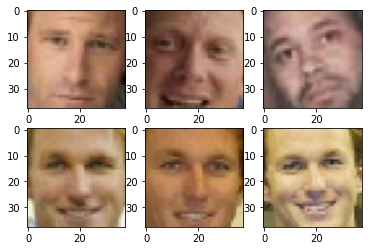

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.title('sample image')
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(X[i].transpose([1,2,0]))

print("X shape:",X.shape)
print("attr shape:",attr.shape)

### Autoencoder architecture

Let's design autoencoder as a single lasagne network, going from input image through bottleneck into the reconstructed image.

<img src="http://nghiaho.com/wp-content/uploads/2012/12/autoencoder_network1.png" width=640px>



## First step: PCA

Principial Component Analysis is a popular dimensionality reduction method. 

Under the hood, PCA attempts to decompose object-feature matrix $X$ into two smaller matrices: $W$ and $\hat W$ minimizing _mean squared error_:

$$\|(X W) \hat{W} - X\|^2_2 \to_{W, \hat{W}} \min$$
- $X \in \mathbb{R}^{n \times m}$ - object matrix (**centered**);
- $W \in \mathbb{R}^{m \times d}$ - matrix of direct transformation;
- $\hat{W} \in \mathbb{R}^{d \times m}$ - matrix of reverse transformation;
- $n$ samples, $m$ original dimensions and $d$ target dimensions;

In geometric terms, we want to find d axes along which most of variance occurs. The "natural" axes, if you wish.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/9/90/PCA_fish.png/256px-PCA_fish.png)


PCA can also be seen as a special case of an autoencoder.

* __Encoder__: X -> Dense(d units) -> code
* __Decoder__: code -> Dense(m units) -> X

Where Dense is a fully-connected layer with linear activaton:   $f(X) = W \cdot X + \vec b $


Note: the bias term in those layers is responsible for "centering" the matrix i.e. substracting mean.

In [ ]:
class Reshape(nn.Module):
    """ this class corresponds to torch.reshape function and may be used as a reshape layer """
    def __init__(self, *shape):
        super().__init__()
        self.shape = shape
    def forward(self, input):
        return input.reshape(*self.shape)

In [ ]:
class PCAAutoencoder(nn.Module):
    """
    Here we define a simple linear autoencoder as described above.
    We also flatten and un-flatten data to be compatible with image shapes
    """
    
    def __init__(self, code_size=50):
        super(PCAAutoencoder, self).__init__()
        self.enc = nn.Sequential(Reshape(-1, np.prod(img_shape)), nn.Linear(np.prod(img_shape), code_size))
        self.dec = nn.Sequential(nn.Linear(code_size, np.prod(img_shape)), Reshape(-1, img_shape[0], img_shape[1], img_shape[2])) 
    
    def batch_loss(self, batch, reference):
        # reconstruction = #<Your code: define reconstruction object>
        reconstruction=self.dec(self.enc(batch))
        return torch.mean((reference - reconstruction) ** 2)
    

### Train the model

As usual, iterate minibatches of data and call train_step, then evaluate loss on validation data.

__Note to py2 users:__ you can safely drop `flush=True` from any code below.

In [ ]:
from tqdm import tqdm
def train(model, dataset, dataset_test, num_epoch=32, gd=None, noise_function=None, noise_function_params=None):
    model.double()
    model.to(device)
    if gd is None:
        gd = optim.Adamax(model.parameters(), lr=0.002)
    if noise_function_params is None:
        noise_function_params = {}
    
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    losses = []
    dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True)
    scores = []

    for epoch in range(num_epoch):
        model.train(True)
        for i, (batch) in tqdm(enumerate(dataloader)):
            gd.zero_grad()
            if noise_function is not None:
                batch_noised = noise_function(batch, **noise_function_params).to(device=device)
                loss = model.batch_loss(batch_noised, batch.to(device=device))
            else:
                batch = batch.to(device=device)
                loss = model.batch_loss(batch, batch)
            (loss).backward()
            losses.append(loss.data.cpu().numpy())
            gd.step()
            gd.zero_grad()
        train_mse = np.mean(losses[-(i+1):])
        
        model.train(False)
        for i, (batch) in enumerate(dataloader_test):
            batch = batch.to(device=device)
            scores.append(model.batch_loss(batch, batch).data.cpu().numpy())
        test_mse  = np.mean(scores[-(i+1):])

        print(f"{epoch+1}, Train loss: {train_mse}, Test loss: {test_mse}")

In [ ]:
def visualize(img, model):
    """Draws original, encoded and decoded images"""
    model.train(False)
    code = model.enc(img[None].cuda(device=device))

    reco = model.dec(code)

    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(img.cpu().numpy().transpose([1, 2, 0]).clip(0, 1))

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.cpu().detach().numpy().reshape([code.shape[-1] // 2, -1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    plt.imshow(reco[0].cpu().detach().numpy().transpose([1, 2, 0]).clip(0, 1))
    plt.show()


In [ ]:
aenc = PCAAutoencoder()
train(aenc, X_train_tensor, X_test_tensor, 40)

370it [00:01, 324.37it/s]


1, Train loss: 0.11292906883110172, Test loss: 0.02479681038773776


370it [00:00, 370.82it/s]


2, Train loss: 0.023434601122824878, Test loss: 0.023605703170273804


370it [00:01, 356.11it/s]


3, Train loss: 0.022945705777908606, Test loss: 0.023456740002535996


370it [00:01, 312.93it/s]


4, Train loss: 0.022713818926709612, Test loss: 0.022841550758135428


370it [00:01, 353.78it/s]


5, Train loss: 0.022440948141663534, Test loss: 0.02246007793649935


370it [00:01, 322.41it/s]


6, Train loss: 0.021996303340531657, Test loss: 0.021774937418836182


370it [00:01, 366.53it/s]


7, Train loss: 0.021109681147076318, Test loss: 0.020852316941379654


370it [00:01, 364.68it/s]


8, Train loss: 0.01966201736823354, Test loss: 0.019056552444945092


370it [00:01, 354.76it/s]


9, Train loss: 0.01797457600326095, Test loss: 0.018414245742842093


370it [00:01, 364.59it/s]


10, Train loss: 0.016580295613801154, Test loss: 0.01628085321126636


370it [00:01, 355.94it/s]


11, Train loss: 0.015130606808334127, Test loss: 0.014392545418754087


370it [00:01, 365.18it/s]


12, Train loss: 0.013842715452581296, Test loss: 0.013581910686645866


370it [00:01, 321.93it/s]


13, Train loss: 0.012732511297185571, Test loss: 0.012363974444705531


370it [00:01, 309.62it/s]


14, Train loss: 0.011729748857272486, Test loss: 0.011273757923712288


370it [00:01, 348.55it/s]


15, Train loss: 0.010894800585102582, Test loss: 0.010581881941110477


370it [00:00, 374.12it/s]


16, Train loss: 0.010218210379802186, Test loss: 0.009824381489472511


370it [00:01, 358.10it/s]


17, Train loss: 0.009515608320046687, Test loss: 0.009886226547555162


370it [00:01, 321.24it/s]


18, Train loss: 0.009175928986906782, Test loss: 0.008680776742663295


370it [00:01, 355.89it/s]


19, Train loss: 0.008572858092599929, Test loss: 0.008508577189082735


370it [00:01, 363.91it/s]


20, Train loss: 0.00831384872281669, Test loss: 0.008612261735645789


370it [00:01, 361.87it/s]


21, Train loss: 0.007981941339265835, Test loss: 0.0077338609447989825


370it [00:01, 263.67it/s]


22, Train loss: 0.007652310225739733, Test loss: 0.007447311424586229


370it [00:01, 342.30it/s]


23, Train loss: 0.007402840147598999, Test loss: 0.007458435617236444


370it [00:01, 362.69it/s]


24, Train loss: 0.007273957092857911, Test loss: 0.007303883113484762


370it [00:00, 373.42it/s]


25, Train loss: 0.007140538480691331, Test loss: 0.007407965121211018


370it [00:01, 360.08it/s]


26, Train loss: 0.006932781105262321, Test loss: 0.00689386824348022


370it [00:01, 347.07it/s]


27, Train loss: 0.00678038378268258, Test loss: 0.0067445743510708995


370it [00:01, 335.59it/s]


28, Train loss: 0.006680633123633171, Test loss: 0.006684251598769796


370it [00:01, 350.93it/s]


29, Train loss: 0.006535982405982674, Test loss: 0.0075344733462666255


370it [00:01, 332.10it/s]


30, Train loss: 0.006445715979159973, Test loss: 0.006468191277964439


370it [00:01, 353.81it/s]


31, Train loss: 0.00639905714106739, Test loss: 0.00639098369540279


370it [00:01, 362.43it/s]


32, Train loss: 0.006330487288932701, Test loss: 0.006300549928010836


370it [00:01, 360.67it/s]


33, Train loss: 0.006220630384124336, Test loss: 0.006119366233359698


370it [00:01, 358.13it/s]


34, Train loss: 0.006238613934896082, Test loss: 0.006185136837896596


370it [00:01, 359.73it/s]


35, Train loss: 0.006105183187998586, Test loss: 0.006202143549120016


370it [00:01, 333.78it/s]


36, Train loss: 0.006091993482419739, Test loss: 0.0060604287656766875


370it [00:01, 354.50it/s]


37, Train loss: 0.006017207845916262, Test loss: 0.006103346431717747


370it [00:01, 364.84it/s]


38, Train loss: 0.005976306977250305, Test loss: 0.005980919392435017


370it [00:01, 359.13it/s]


39, Train loss: 0.006010847490357079, Test loss: 0.006005695480023542


370it [00:01, 369.66it/s]


40, Train loss: 0.00597411063690943, Test loss: 0.005943698042064664


In [ ]:
dataloader_test = DataLoader(X_test_tensor, batch_size=BATCH_SIZE, shuffle=True)
scores = []
for i, (batch) in enumerate(dataloader_test):
    batch = batch.to(device=device)
    scores.append(aenc.batch_loss(batch, batch).data.cpu().numpy())
print (np.mean(scores))

0.005952391780821532


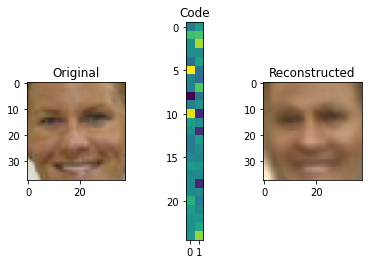

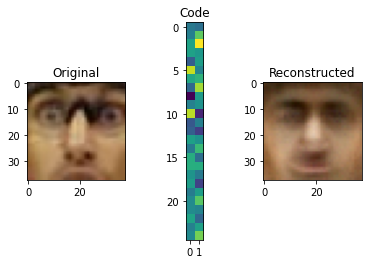

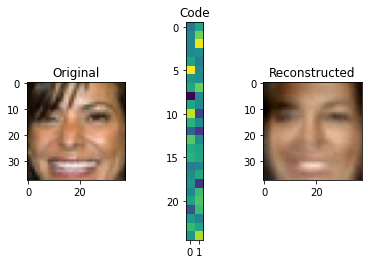

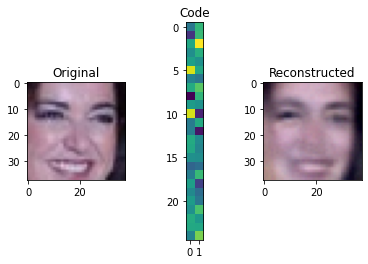

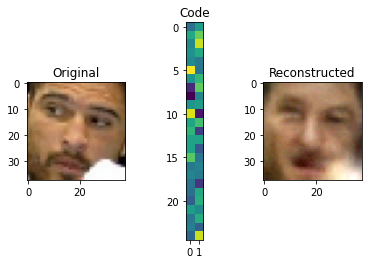

In [ ]:
for i in range(5):
    img = X_test_tensor[i]
    visualize(img, aenc)


### Going deeper

PCA is neat but surely we can do better. This time we want you to build a deep autoencoder by... stacking more layers.

In particular, your encoder and decoder should be at least 3 layers deep each. You can use any nonlinearity you want and any number of hidden units in non-bottleneck layers provided you can actually afford training it.

![layers](https://pbs.twimg.com/media/CYggEo-VAAACg_n.png:small)

A few sanity checks:
* There shouldn't be any hidden layer smaller than bottleneck (encoder output).
* Don't forget to insert nonlinearities between intermediate dense layers.
* Convolutional layers are allowed but not required. To undo convolution use L.Deconv2D, pooling - L.UpSampling2D.
* Adding activation after bottleneck is allowed, but not strictly necessary.

In [ ]:
activation=nn.GELU()

In [ ]:
class DeepAutoencoder(nn.Module):
    def __init__(self, code_size=50):
        super(DeepAutoencoder, self).__init__()
        # self.enc = #<Your code: define encoder as per instructions above>
        self.enc=nn.Sequential (
            Reshape(-1, np.prod(img_shape)),
            # nn.LazyLinear(4096),
            # nn.ReLU(),
            # nn.LazyLinear(2048),
            # nn.ReLU(),
            # nn.LazyLinear(1024),
            # nn.ReLU(),
            nn.LazyLinear(512),
            activation,
            nn.LazyLinear(256),
            activation,
            nn.LazyLinear(128),
            activation,
            nn.LazyLinear(code_size),
        )
        # self.dec = #<Your code: define decoder as per instructions above>
        self.dec=nn.Sequential (
            nn.LazyLinear(128),
            activation,
            nn.LazyLinear(256),
            activation,
            nn.LazyLinear(512),
            activation,
            # nn.LazyLinear(1024),
            # nn.ReLU(),
            # nn.LazyLinear(2048),
            # nn.ReLU(),
            # nn.LazyLinear(4096),
            # nn.ReLU(),
            nn.LazyLinear(np.prod(img_shape)),
            activation,
            Reshape(-1, img_shape[0], img_shape[1], img_shape[2]),
        )
    
    def batch_loss(self, batch, reference):
        a = self.enc(batch)
        reconstruction = self.dec(a)
        return torch.mean((reference - reconstruction)**2)

In [ ]:
#Check autoencoder shapes along different code_sizes
get_dim = lambda layer: np.prod(layer.output_shape[1:])
for code_size in [1,8,32,128,512,1024]:
    help_tensor = next(iter(DataLoader(X_train_tensor, batch_size=BATCH_SIZE)))
    model = DeepAutoencoder(code_size).double().to(device)
    encoder_out = model.enc(help_tensor.cuda(device))
    decoder_out = model.dec(encoder_out)
    print("Testing code size %i" % code_size)

    assert encoder_out.shape[1:] == torch.Size([code_size]),"encoder must output a code of required size"
    assert decoder_out.shape[1:] == img_shape,   "decoder must output an image of valid shape"

    assert (sum([1 + len(list(c1level.children())) for c1level in model.dec.children()]) >= 6),  "decoder must contain at least 3 dense layers"

    del encoder_out
    del decoder_out
    torch.cuda.empty_cache()
print("All tests passed!")

Testing code size 1
Testing code size 8
Testing code size 32
Testing code size 128
Testing code size 512
Testing code size 1024
All tests passed!


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


__Hint:__ if you're getting "Encoder layer is smaller than bottleneck" error, use code_size when defining intermediate layers. 

For example, such layer may have code_size*2 units.

In [ ]:
aenc_deep = DeepAutoencoder()
train(aenc_deep, X_train_tensor, X_test_tensor, num_epoch=100)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
370it [00:02, 162.80it/s]


1, Train loss: 0.028859499297307304, Test loss: 0.022816250978616993


370it [00:02, 160.71it/s]


2, Train loss: 0.022196003882538097, Test loss: 0.022400195767590052


370it [00:02, 162.46it/s]


3, Train loss: 0.020190047768798985, Test loss: 0.016962413305011158


370it [00:02, 143.67it/s]


4, Train loss: 0.01622357214329801, Test loss: 0.016219570132389064


370it [00:02, 164.11it/s]


5, Train loss: 0.015182713357492814, Test loss: 0.01485352240176407


370it [00:02, 161.03it/s]


6, Train loss: 0.014105058357060036, Test loss: 0.014172201728426306


370it [00:02, 148.58it/s]


7, Train loss: 0.013481011631808893, Test loss: 0.013458463756487314


370it [00:02, 160.85it/s]


8, Train loss: 0.012730116216074748, Test loss: 0.012520872612959734


370it [00:02, 148.50it/s]


9, Train loss: 0.01186751378323258, Test loss: 0.011617456680944695


370it [00:02, 153.58it/s]


10, Train loss: 0.011402824985749002, Test loss: 0.011435087496868248


370it [00:02, 143.43it/s]


11, Train loss: 0.011079462092230402, Test loss: 0.01102187392288309


370it [00:02, 150.86it/s]


12, Train loss: 0.010420456002374933, Test loss: 0.010186714610709378


370it [00:02, 170.01it/s]


13, Train loss: 0.009776198351230619, Test loss: 0.010307656023235169


370it [00:02, 154.49it/s]


14, Train loss: 0.009561263189989651, Test loss: 0.009724370898253972


370it [00:02, 170.87it/s]


15, Train loss: 0.009411473492419385, Test loss: 0.009467479344578212


370it [00:02, 161.52it/s]


16, Train loss: 0.009070265558634322, Test loss: 0.009270924570434715


370it [00:02, 147.79it/s]


17, Train loss: 0.008716745514521578, Test loss: 0.00901232128998857


370it [00:02, 163.18it/s]


18, Train loss: 0.008495120559588206, Test loss: 0.008697228286868645


370it [00:02, 150.53it/s]


19, Train loss: 0.00823612620801398, Test loss: 0.008321091077866228


370it [00:02, 158.36it/s]


20, Train loss: 0.00801086985862743, Test loss: 0.008118944977506945


370it [00:02, 170.77it/s]


21, Train loss: 0.00776653298506082, Test loss: 0.007814332599594742


370it [00:02, 142.22it/s]


22, Train loss: 0.0076071390103455835, Test loss: 0.007681028954100995


370it [00:02, 166.96it/s]


23, Train loss: 0.007489537106040705, Test loss: 0.00772349198133647


370it [00:02, 165.25it/s]


24, Train loss: 0.007423582877314247, Test loss: 0.0075947431193638445


370it [00:02, 140.88it/s]


25, Train loss: 0.007304499218733905, Test loss: 0.007576302437589348


370it [00:02, 161.84it/s]


26, Train loss: 0.0071795019462560184, Test loss: 0.007376358817045938


370it [00:02, 151.54it/s]


27, Train loss: 0.007060560660429214, Test loss: 0.007263566312742113


370it [00:02, 147.06it/s]


28, Train loss: 0.006932522187454423, Test loss: 0.007371187004333067


370it [00:02, 161.03it/s]


29, Train loss: 0.006851198205873889, Test loss: 0.007075107426752268


370it [00:02, 170.16it/s]


30, Train loss: 0.006754610461844888, Test loss: 0.007140255780264847


370it [00:02, 167.13it/s]


31, Train loss: 0.006702755305669112, Test loss: 0.007024719089240474


370it [00:02, 164.61it/s]


32, Train loss: 0.006612152323539305, Test loss: 0.006845380372320315


370it [00:02, 166.23it/s]


33, Train loss: 0.00649458814846236, Test loss: 0.00685705809234323


370it [00:02, 170.63it/s]


34, Train loss: 0.006472693573010515, Test loss: 0.006906273788373311


370it [00:02, 155.14it/s]


35, Train loss: 0.006389444119093141, Test loss: 0.006716177486558914


370it [00:02, 161.91it/s]


36, Train loss: 0.006314437547372783, Test loss: 0.006776057239118694


370it [00:02, 169.42it/s]


37, Train loss: 0.006229848331668611, Test loss: 0.006610907476394555


370it [00:02, 168.16it/s]


38, Train loss: 0.0061501893968569765, Test loss: 0.006510500586073712


370it [00:02, 154.59it/s]


39, Train loss: 0.006074842304426542, Test loss: 0.006512456988026012


370it [00:02, 168.27it/s]


40, Train loss: 0.006036934140086235, Test loss: 0.006458561946091583


370it [00:02, 151.09it/s]


41, Train loss: 0.006002941069559234, Test loss: 0.00638170595656998


370it [00:02, 155.67it/s]


42, Train loss: 0.005928304391758293, Test loss: 0.006325491149069864


370it [00:02, 170.11it/s]


43, Train loss: 0.00587806049667123, Test loss: 0.0062983726246979566


370it [00:02, 166.20it/s]


44, Train loss: 0.005868200268624457, Test loss: 0.006204481285569984


370it [00:02, 166.65it/s]


45, Train loss: 0.005836070329659888, Test loss: 0.006186886705723296


370it [00:02, 162.24it/s]


46, Train loss: 0.005802706580659772, Test loss: 0.0062227125232361975


370it [00:02, 164.85it/s]


47, Train loss: 0.005752197100286165, Test loss: 0.006166032021944767


370it [00:02, 170.54it/s]


48, Train loss: 0.00574948872633318, Test loss: 0.006173318565287724


370it [00:02, 151.16it/s]


49, Train loss: 0.005703296741851794, Test loss: 0.00616185818302758


370it [00:02, 150.06it/s]


50, Train loss: 0.005668293670490677, Test loss: 0.0062074088365261775


370it [00:02, 146.92it/s]


51, Train loss: 0.005637473666515761, Test loss: 0.006234580122862745


370it [00:02, 153.28it/s]


52, Train loss: 0.0055989790573148426, Test loss: 0.006060796919421603


370it [00:02, 166.85it/s]


53, Train loss: 0.005574054883597237, Test loss: 0.006065879497361091


370it [00:02, 167.69it/s]


54, Train loss: 0.005540870392637933, Test loss: 0.005993703520324064


370it [00:02, 168.87it/s]


55, Train loss: 0.005513032928584307, Test loss: 0.005911242711982549


370it [00:02, 152.65it/s]


56, Train loss: 0.005479800883900916, Test loss: 0.005975706050173078


370it [00:02, 157.29it/s]


57, Train loss: 0.005466120021002144, Test loss: 0.005997899417752051


370it [00:02, 152.92it/s]


58, Train loss: 0.005425251059533191, Test loss: 0.005911183951594699


370it [00:02, 160.18it/s]


59, Train loss: 0.0054097437699849775, Test loss: 0.005862083067496684


370it [00:02, 154.00it/s]


60, Train loss: 0.005391474977295472, Test loss: 0.005827195601339743


370it [00:02, 149.92it/s]


61, Train loss: 0.005371398584926662, Test loss: 0.00585695335521432


370it [00:02, 159.33it/s]


62, Train loss: 0.0053403104829726, Test loss: 0.005827906256766868


370it [00:02, 162.62it/s]


63, Train loss: 0.005313946199444911, Test loss: 0.005782454740328187


370it [00:02, 165.40it/s]


64, Train loss: 0.005309087854836998, Test loss: 0.005888568233248169


370it [00:02, 152.49it/s]


65, Train loss: 0.005259953159372775, Test loss: 0.005733438549702


370it [00:02, 161.78it/s]


66, Train loss: 0.005251732087107431, Test loss: 0.005712084802739115


370it [00:02, 152.00it/s]


67, Train loss: 0.005208215112262235, Test loss: 0.005629215783805687


370it [00:02, 165.00it/s]


68, Train loss: 0.0052011918088142725, Test loss: 0.0056594055275183824


370it [00:02, 135.65it/s]


69, Train loss: 0.005195845451567532, Test loss: 0.005745576210741574


370it [00:02, 163.04it/s]


70, Train loss: 0.005170592421059923, Test loss: 0.005720852448200662


370it [00:02, 169.16it/s]


71, Train loss: 0.005138069168382356, Test loss: 0.00566404038842792


370it [00:02, 152.34it/s]


72, Train loss: 0.005138473449274472, Test loss: 0.005639952020943296


370it [00:02, 165.57it/s]


73, Train loss: 0.005116777458064606, Test loss: 0.00564522375101207


370it [00:02, 151.45it/s]


74, Train loss: 0.005104365440240844, Test loss: 0.005781505977679476


370it [00:02, 156.27it/s]


75, Train loss: 0.0051019188018629775, Test loss: 0.0055637807761028365


370it [00:02, 163.94it/s]


76, Train loss: 0.005085898963857079, Test loss: 0.005706847773113919


370it [00:02, 159.98it/s]


77, Train loss: 0.005081105119665345, Test loss: 0.005670957983952922


370it [00:02, 164.07it/s]


78, Train loss: 0.005066067113094376, Test loss: 0.005663897989556128


370it [00:02, 153.34it/s]


79, Train loss: 0.005061750290061438, Test loss: 0.005672187927135679


370it [00:02, 160.65it/s]


80, Train loss: 0.005032051865592782, Test loss: 0.0056773797065394855


370it [00:02, 158.15it/s]


81, Train loss: 0.005038222675028213, Test loss: 0.005543113100505273


370it [00:02, 150.68it/s]


82, Train loss: 0.004996311223298973, Test loss: 0.005627313064987319


370it [00:02, 162.61it/s]


83, Train loss: 0.004999860469210438, Test loss: 0.0057776504274411195


370it [00:02, 163.57it/s]


84, Train loss: 0.004982557617340439, Test loss: 0.005572659379833901


370it [00:02, 149.97it/s]


85, Train loss: 0.004973956142576406, Test loss: 0.005700381936979996


370it [00:02, 157.93it/s]


86, Train loss: 0.0049597695974076235, Test loss: 0.005650916399215114


370it [00:02, 146.26it/s]


87, Train loss: 0.004950343424763041, Test loss: 0.005502096402437602


370it [00:02, 160.74it/s]


88, Train loss: 0.00493717356207823, Test loss: 0.005607292098694198


370it [00:02, 161.80it/s]


89, Train loss: 0.004928854585022085, Test loss: 0.005668589747861911


370it [00:02, 161.65it/s]


90, Train loss: 0.004903671534512363, Test loss: 0.005589232885803945


370it [00:02, 149.06it/s]


91, Train loss: 0.004905874950417891, Test loss: 0.005494940479277462


370it [00:02, 153.13it/s]


92, Train loss: 0.004881262629545804, Test loss: 0.005585370712720194


370it [00:02, 161.87it/s]


93, Train loss: 0.004896123178742526, Test loss: 0.005486868605968169


370it [00:02, 166.23it/s]


94, Train loss: 0.004870086003371066, Test loss: 0.0057551592592450865


370it [00:02, 145.95it/s]


95, Train loss: 0.004890694491625891, Test loss: 0.005670068838945949


370it [00:02, 142.94it/s]


96, Train loss: 0.004836224708759056, Test loss: 0.005481403011717574


370it [00:02, 141.70it/s]


97, Train loss: 0.004859214877241583, Test loss: 0.005684564541416781


370it [00:02, 151.02it/s]


98, Train loss: 0.004854303760663573, Test loss: 0.005627841528442832


370it [00:02, 146.47it/s]


99, Train loss: 0.004825804717061133, Test loss: 0.005491732168178097


370it [00:02, 160.16it/s]


100, Train loss: 0.004833371255485823, Test loss: 0.0055853053837697465


In [ ]:
train(aenc_deep, X_train_tensor, X_test_tensor, num_epoch=100)

370it [00:02, 145.82it/s]


1, Train loss: 0.008818868060815445, Test loss: 0.006298415269504807


370it [00:02, 156.16it/s]


2, Train loss: 0.005409693933582753, Test loss: 0.005679669318371598


370it [00:02, 147.97it/s]


3, Train loss: 0.0049650686875463155, Test loss: 0.005443693324967246


370it [00:02, 155.36it/s]


4, Train loss: 0.004792824243115292, Test loss: 0.005369801127263963


370it [00:02, 160.07it/s]


5, Train loss: 0.004733186067501552, Test loss: 0.0053035295556834935


370it [00:02, 150.95it/s]


6, Train loss: 0.004724711007026908, Test loss: 0.005322041326826192


370it [00:02, 156.44it/s]


7, Train loss: 0.004730290584886069, Test loss: 0.005384187986470489


370it [00:02, 164.58it/s]


8, Train loss: 0.00474916102011239, Test loss: 0.005372829730511476


370it [00:02, 168.81it/s]


9, Train loss: 0.00477372114896398, Test loss: 0.0054317371016767094


370it [00:02, 162.96it/s]


10, Train loss: 0.004801643386330843, Test loss: 0.005473968158232009


370it [00:02, 142.99it/s]


11, Train loss: 0.004792037761780068, Test loss: 0.00546715349968378


370it [00:02, 153.59it/s]


12, Train loss: 0.004793139496264771, Test loss: 0.005408207607335609


370it [00:02, 164.76it/s]


13, Train loss: 0.004796650351324854, Test loss: 0.005448613795639063


370it [00:02, 149.56it/s]


14, Train loss: 0.00478766012527736, Test loss: 0.005515061964294508


370it [00:02, 149.00it/s]


15, Train loss: 0.004780478467270836, Test loss: 0.005445726762837247


370it [00:02, 165.89it/s]


16, Train loss: 0.004775723501396432, Test loss: 0.00543843194583976


370it [00:02, 164.39it/s]


17, Train loss: 0.004769633675454106, Test loss: 0.005434686827577252


370it [00:02, 154.90it/s]


18, Train loss: 0.004760400668341238, Test loss: 0.005544527936454137


370it [00:02, 164.43it/s]


19, Train loss: 0.004762803489566447, Test loss: 0.005421238302997345


370it [00:02, 158.56it/s]


20, Train loss: 0.004742735009615245, Test loss: 0.0054121191870310096


370it [00:02, 160.21it/s]


21, Train loss: 0.004738986140448783, Test loss: 0.005403331542730266


370it [00:02, 146.69it/s]


22, Train loss: 0.004738364003181237, Test loss: 0.0054749947022238775


370it [00:02, 159.56it/s]


23, Train loss: 0.00472983645195576, Test loss: 0.005570644281874946


370it [00:02, 167.65it/s]


24, Train loss: 0.004718919196811715, Test loss: 0.005408554134782433


370it [00:02, 167.43it/s]


25, Train loss: 0.004730333950954309, Test loss: 0.005444927511411219


370it [00:02, 148.22it/s]


26, Train loss: 0.004711037167393185, Test loss: 0.005422833675924571


370it [00:02, 167.34it/s]


27, Train loss: 0.004700811042085606, Test loss: 0.0054326984096040015


370it [00:02, 165.26it/s]


28, Train loss: 0.004703327104188419, Test loss: 0.005420021224597822


370it [00:02, 160.10it/s]


29, Train loss: 0.004700840593632846, Test loss: 0.005587448158183725


370it [00:02, 159.91it/s]


30, Train loss: 0.004687886394050899, Test loss: 0.005420618018669217


370it [00:02, 167.95it/s]


31, Train loss: 0.004693629369090307, Test loss: 0.005385124902603779


370it [00:02, 159.53it/s]


32, Train loss: 0.00467640270855543, Test loss: 0.005442541498896487


370it [00:02, 155.33it/s]


33, Train loss: 0.0046739299001443664, Test loss: 0.005462779452939207


370it [00:02, 153.93it/s]


34, Train loss: 0.004659580123493719, Test loss: 0.005398835080431312


370it [00:02, 137.69it/s]


35, Train loss: 0.0046584613430167695, Test loss: 0.005438469936484689


370it [00:02, 159.76it/s]


36, Train loss: 0.004669622043301051, Test loss: 0.005542202381014506


370it [00:02, 165.25it/s]


37, Train loss: 0.004658957050487787, Test loss: 0.00543714106565681


370it [00:02, 155.12it/s]


38, Train loss: 0.004653476079593092, Test loss: 0.005584069732282014


370it [00:02, 163.74it/s]


39, Train loss: 0.00465964060484809, Test loss: 0.005457073707054254


370it [00:02, 153.88it/s]


40, Train loss: 0.004652604975366881, Test loss: 0.00550234985465105


370it [00:02, 164.67it/s]


41, Train loss: 0.004637308445705101, Test loss: 0.0055005885490520086


370it [00:02, 168.35it/s]


42, Train loss: 0.004631717895868719, Test loss: 0.005494798099614681


370it [00:02, 168.92it/s]


43, Train loss: 0.004637188011228741, Test loss: 0.005409074638255033


370it [00:02, 168.16it/s]


44, Train loss: 0.0046349826499859584, Test loss: 0.005364814999603709


370it [00:02, 165.66it/s]


45, Train loss: 0.004623736179185631, Test loss: 0.005399208391847844


370it [00:02, 168.25it/s]


46, Train loss: 0.00462330440839375, Test loss: 0.0054300550678573044


370it [00:02, 163.39it/s]


47, Train loss: 0.004616521535393392, Test loss: 0.0055189981192778305


370it [00:02, 163.92it/s]


48, Train loss: 0.004620422751354779, Test loss: 0.00547032929671214


370it [00:02, 163.70it/s]


49, Train loss: 0.004609721266911371, Test loss: 0.005371483792230734


370it [00:02, 146.41it/s]


50, Train loss: 0.004600200419579126, Test loss: 0.005355464788176162


370it [00:02, 169.38it/s]


51, Train loss: 0.004605985466534224, Test loss: 0.005421194690194472


370it [00:02, 156.84it/s]


52, Train loss: 0.0045847219370732375, Test loss: 0.005519081534686788


370it [00:02, 152.88it/s]


53, Train loss: 0.004596149703053293, Test loss: 0.0053895311568084685


42it [00:00, 122.29it/s]


KeyboardInterrupt: ignored

Training may take long, it's okay.

0.005431550539978575
Final MSE: 0.005431550539978575


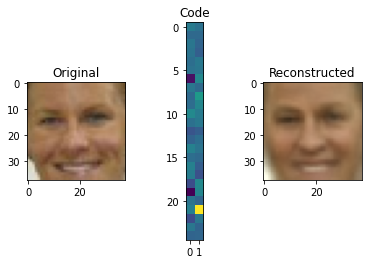

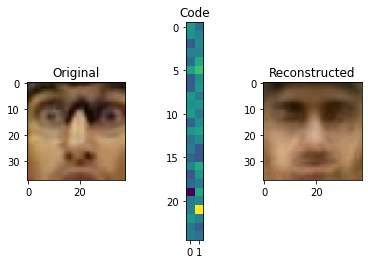

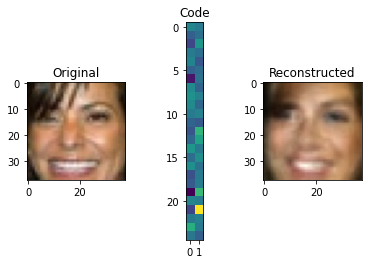

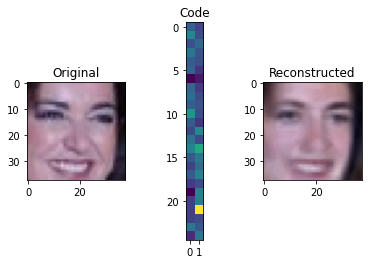

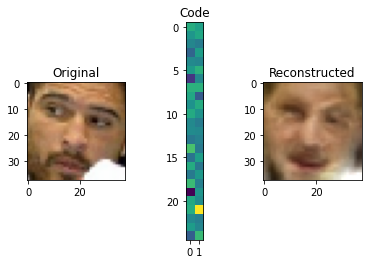

In [ ]:
aenc_deep.train(False)
dataloader_test = DataLoader(X_test_tensor, batch_size=BATCH_SIZE, shuffle=True)
scores = []
for i, (batch) in enumerate(dataloader_test):
    batch = batch.to(device=device)
    scores.append(aenc_deep.batch_loss(batch, batch).data.cpu().numpy())
    encoder_out = aenc_deep.enc(batch)
reconstruction_mse  = np.mean(scores)
print (reconstruction_mse)
assert reconstruction_mse <= 0.0055, "Compression is too lossy. See tips below."
assert len(encoder_out.shape) == 2 and encoder_out.shape[1] == 50, "Make sure encoder has code_size units"
print("Final MSE:", reconstruction_mse)
for i in range(5):
    img = X_test_tensor[i]
    visualize(img,aenc_deep)

__Tips:__ If you keep getting "Compression to lossy" error, there's a few things you might try:

* Make sure it converged. Some architectures need way more than 32 epochs to converge. They may fluctuate a lot, but eventually they're going to get good enough to pass. You may train your network for as long as you want.

* Complexity. If you already have, like, 152 layers and still not passing threshold, you may wish to start from something simpler instead and go in small incremental steps.

* Architecture. You can use any combination of layers (including convolutions, normalization, etc) as long as __encoder output only stores 50 numbers per training object__. 

A cunning learner can circumvent this last limitation by using some manual encoding strategy, but he is strongly recommended to avoid that.

## Denoising AutoEncoder

Let's now make our model into a denoising autoencoder.

We'll keep your model architecture, but change the way it trains. In particular, we'll corrupt it's input data randomly before each epoch.

There are many strategies to apply noise. We'll implement two popular one: adding gaussian noise and using dropout.

In [ ]:
X.shape

(13143, 3, 38, 38)

In [ ]:
def apply_gaussian_noise(X, sigma=0.1):
    """
    adds noise from normal distribution with standard deviation sigma
    :param X: image tensor of shape [batch,height,width,3]
    """
    
    # <Your code: define noise>
    a=X.shape
    noise=torch.normal(mean=0, std=sigma, size=a)
        
    return X + noise
    

In [ ]:
#noise tests
theoretical_std = (X[:100].std() ** 2 + 0.5 ** 2)**.5
our_std = apply_gaussian_noise(torch.from_numpy(X[:100]), sigma=0.5).std()
assert abs(theoretical_std - our_std) < 0.01, "Standard deviation does not match it's required value. Make sure you use sigma as std."
assert abs(apply_gaussian_noise(torch.from_numpy(X[:100]), sigma=0.5).mean() - torch.from_numpy(X[:100]).mean()) < 0.01, "Mean has changed. Please add zero-mean noise"

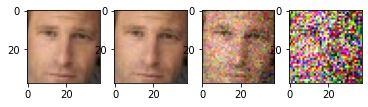

In [ ]:
plt.subplot(1,4,1)
plt.imshow(X[0].transpose([1,2,0]))
plt.subplot(1,4,2)
plt.imshow(apply_gaussian_noise(torch.from_numpy(X[:1]), sigma=0.01).data.numpy()[0].transpose([1,2,0]).clip(0, 1))
plt.subplot(1,4,3)
plt.imshow(apply_gaussian_noise(torch.from_numpy(X[:1]), sigma=0.1).data.numpy()[0].transpose([1,2,0]).clip(0, 1))
plt.subplot(1,4,4)
plt.imshow(apply_gaussian_noise(torch.from_numpy(X[:1]), sigma=0.5).data.numpy()[0].transpose([1,2,0]).clip(0, 1))

In [ ]:
aenc = DeepAutoencoder()
train(aenc, X_train_tensor, X_test_tensor, 50, noise_function=apply_gaussian_noise)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
370it [00:03, 115.18it/s]


1, Train loss: 0.025611443657561735, Test loss: 0.022096291669572103


370it [00:03, 122.94it/s]


2, Train loss: 0.0188792421758737, Test loss: 0.016177305019298656


370it [00:03, 116.64it/s]


3, Train loss: 0.015155213571560959, Test loss: 0.014494664291623058


370it [00:03, 118.18it/s]


4, Train loss: 0.014103598254850568, Test loss: 0.01436736270231246


370it [00:03, 114.95it/s]


5, Train loss: 0.013299161266600685, Test loss: 0.013164348897987515


370it [00:03, 123.15it/s]


6, Train loss: 0.012473251422293039, Test loss: 0.012177037845115948


370it [00:03, 122.52it/s]


7, Train loss: 0.011612417743666151, Test loss: 0.011470562869952865


370it [00:03, 112.94it/s]


8, Train loss: 0.010988055767797461, Test loss: 0.010835374796758127


370it [00:03, 116.14it/s]


9, Train loss: 0.010688534502570159, Test loss: 0.010789324759977082


370it [00:03, 117.98it/s]


10, Train loss: 0.010486305846673304, Test loss: 0.010487926463181514


370it [00:03, 120.79it/s]


11, Train loss: 0.010164395975206061, Test loss: 0.010046264502246499


370it [00:03, 115.89it/s]


12, Train loss: 0.009725986208701402, Test loss: 0.009863474886791783


370it [00:03, 114.80it/s]


13, Train loss: 0.009486267093717481, Test loss: 0.009882719464532194


370it [00:03, 119.33it/s]


14, Train loss: 0.009144393435371127, Test loss: 0.009312494772900174


370it [00:03, 121.29it/s]


15, Train loss: 0.008931640937519823, Test loss: 0.008971898641714533


370it [00:03, 117.10it/s]


16, Train loss: 0.008747952484713323, Test loss: 0.008646934909169582


370it [00:03, 117.11it/s]


17, Train loss: 0.008479065657872958, Test loss: 0.00870194916921035


370it [00:03, 115.47it/s]


18, Train loss: 0.008293792880314793, Test loss: 0.008667088168414572


370it [00:02, 125.01it/s]


19, Train loss: 0.008083713298793429, Test loss: 0.008085130478554954


370it [00:03, 116.66it/s]


20, Train loss: 0.007899890783873273, Test loss: 0.00810929902846357


370it [00:03, 115.94it/s]


21, Train loss: 0.007763088364393976, Test loss: 0.007944931957056976


370it [00:03, 122.73it/s]


22, Train loss: 0.007691651322907164, Test loss: 0.007903299032007063


370it [00:03, 118.91it/s]


23, Train loss: 0.007558796155738359, Test loss: 0.007615582845078943


370it [00:03, 119.91it/s]


24, Train loss: 0.007459411499203618, Test loss: 0.007681190700275502


370it [00:03, 111.97it/s]


25, Train loss: 0.007369164663745615, Test loss: 0.00770605083306503


370it [00:03, 116.98it/s]


26, Train loss: 0.007298927770149403, Test loss: 0.007440953975594048


370it [00:03, 122.83it/s]


27, Train loss: 0.007170884828943184, Test loss: 0.007332065610720062


370it [00:03, 122.93it/s]


28, Train loss: 0.007104115694602765, Test loss: 0.0072600333300660925


370it [00:03, 120.14it/s]


29, Train loss: 0.006999146007135352, Test loss: 0.007386693932295336


370it [00:03, 116.76it/s]


30, Train loss: 0.00690765326626432, Test loss: 0.0072705019326736375


370it [00:03, 114.63it/s]


31, Train loss: 0.006823536147850704, Test loss: 0.007077980036943112


370it [00:03, 119.18it/s]


32, Train loss: 0.006749690288669595, Test loss: 0.007100173823828854


370it [00:03, 116.97it/s]


33, Train loss: 0.00668657440763522, Test loss: 0.006845747800544089


370it [00:03, 113.58it/s]


34, Train loss: 0.006603608815002457, Test loss: 0.006891038364233979


370it [00:03, 121.25it/s]


35, Train loss: 0.0065683634243496845, Test loss: 0.007003054738683911


370it [00:03, 115.07it/s]


36, Train loss: 0.0065233107712825995, Test loss: 0.006848055381854627


370it [00:03, 122.92it/s]


37, Train loss: 0.00645532525800862, Test loss: 0.0068216139337344255


370it [00:03, 113.14it/s]


38, Train loss: 0.006415868187753949, Test loss: 0.00674477117203547


370it [00:03, 105.01it/s]


39, Train loss: 0.00639290590944948, Test loss: 0.006762055387606363


370it [00:03, 109.50it/s]


40, Train loss: 0.006332301254654935, Test loss: 0.006666846019957003


370it [00:03, 120.27it/s]


41, Train loss: 0.0063177580137941955, Test loss: 0.006582821404488006


370it [00:03, 117.94it/s]


42, Train loss: 0.006207671076345746, Test loss: 0.006479597264301862


370it [00:03, 123.32it/s]


43, Train loss: 0.006201077238962325, Test loss: 0.006559404959670589


370it [00:03, 120.78it/s]


44, Train loss: 0.006153847253615928, Test loss: 0.006552839471796902


370it [00:03, 116.09it/s]


45, Train loss: 0.0061305570948734876, Test loss: 0.006469788930734514


370it [00:03, 118.57it/s]


46, Train loss: 0.00609208085106094, Test loss: 0.006638215197990012


370it [00:03, 115.65it/s]


47, Train loss: 0.006061610164387572, Test loss: 0.00647777466239339


370it [00:03, 123.22it/s]


48, Train loss: 0.0060150166219841835, Test loss: 0.006366042445646423


370it [00:03, 112.30it/s]


49, Train loss: 0.005990119078417679, Test loss: 0.006339094904711762


370it [00:03, 111.47it/s]


50, Train loss: 0.005956928138542499, Test loss: 0.006226261400946358


__Note:__ if it hasn't yet converged, increase the number of iterations.

__Bonus:__ replace gaussian noise with masking random rectangles on image.

Final MSE: 0.006305537510382983


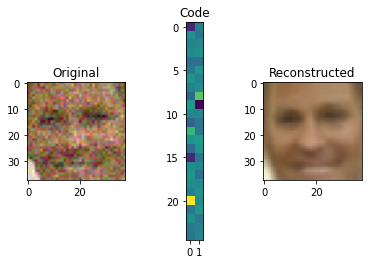

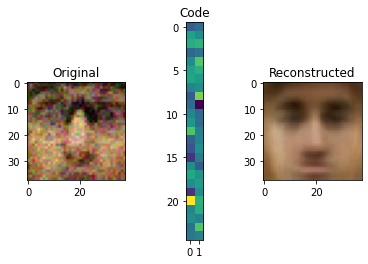

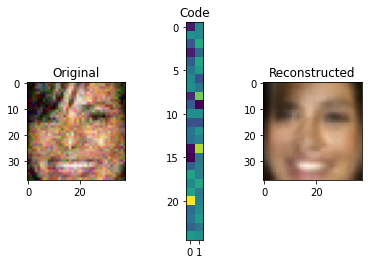

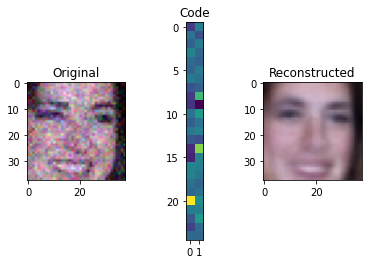

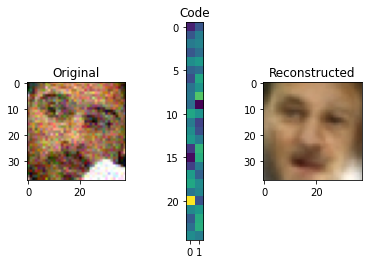

In [ ]:
dataloader_test = DataLoader(X_test_tensor, batch_size=BATCH_SIZE, shuffle=True)
scores = []
for i, (batch) in enumerate(dataloader_test):
    batch_noised = apply_gaussian_noise(batch).to(device=device)
    scores.append(aenc.batch_loss(batch_noised, batch.cuda(device = device)).data.cpu().numpy())
    encoder_out = aenc.enc(batch_noised)
reconstruction_mse  = np.mean(scores)

print("Final MSE:", reconstruction_mse)
for i in range(5):
    img = apply_gaussian_noise(X_test_tensor[i])
    visualize(img,aenc)

### Image retrieval with autoencoders

So we've just trained a network that converts image into itself imperfectly. This task is not that useful in and of itself, but it has a number of awesome side-effects. Let's see it in action.

First thing we can do is image retrieval aka image search. We we give it an image and find similar images in latent space. 

To speed up retrieval process, we shall use Locality-Sensitive Hashing on top of encoded vectors. We'll use scikit-learn's implementation for simplicity. In practical scenario, you may want to use [specialized libraries](https://erikbern.com/2015/07/04/benchmark-of-approximate-nearest-neighbor-libraries.html) for better performance and customization.

In [ ]:
#encodes batch of images into a codes


# codes = <encode all images in X_train_tensor>

codes=aenc.enc(X_train_tensor.to(device))

In [ ]:
assert codes.shape[0] == X_train_tensor.shape[0]

In [ ]:
!pip uninstall sklearn

Found existing installation: sklearn 0.0
Uninstalling sklearn-0.0:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/sklearn-0.0.dist-info/*
Proceed (y/n)? y
  Successfully uninstalled sklearn-0.0


In [ ]:
!pip install --exists-action=i scikit-learn

In [ ]:
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes.detach().cpu().numpy())

ImportError: ignored

In [ ]:
images = torch.from_numpy(X_train).type(torch.DoubleTensor)

In [ ]:
def get_similar(image, n_neighbors=5):
    assert len(image.shape) == 3, "image must be [batch, 3, height, width]"

    code = aenc.enc(image.cuda(device)).detach().cpu().numpy()
    
    (distances,),(idx,) = lshf.kneighbors(code,n_neighbors=n_neighbors)
    
    return distances,images[idx]

In [ ]:
def show_similar(image):
    distances, neighbors = get_similar(image,n_neighbors=11)
    
    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")
    
    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

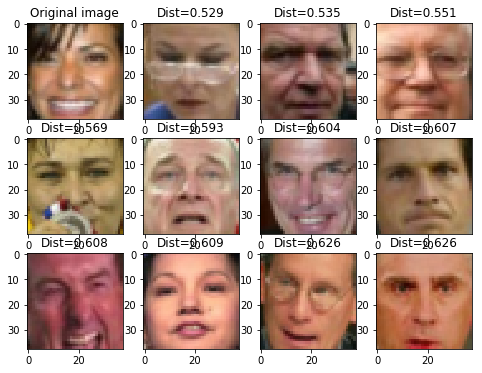

In [ ]:
#smiles
show_similar(X_test_tensor[2])

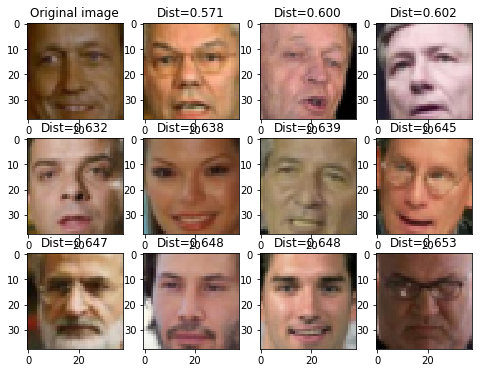

In [ ]:
#ethnicity
show_similar(X_test_tensor[500])

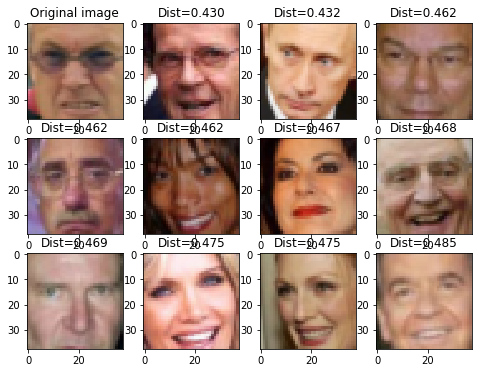

In [ ]:
#glasses
show_similar(X_test_tensor[66])

## Bonus: cheap image morphing


torch.Size([38, 38, 3])
torch.Size([38, 38, 3])
torch.Size([38, 38, 3])
torch.Size([38, 38, 3])
torch.Size([38, 38, 3])
torch.Size([38, 38, 3])
torch.Size([38, 38, 3])


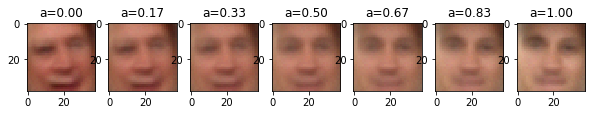

torch.Size([38, 38, 3])
torch.Size([38, 38, 3])
torch.Size([38, 38, 3])
torch.Size([38, 38, 3])
torch.Size([38, 38, 3])
torch.Size([38, 38, 3])
torch.Size([38, 38, 3])


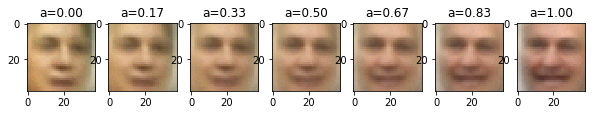

torch.Size([38, 38, 3])
torch.Size([38, 38, 3])
torch.Size([38, 38, 3])
torch.Size([38, 38, 3])
torch.Size([38, 38, 3])
torch.Size([38, 38, 3])
torch.Size([38, 38, 3])


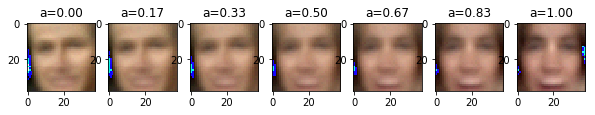

torch.Size([38, 38, 3])
torch.Size([38, 38, 3])
torch.Size([38, 38, 3])
torch.Size([38, 38, 3])
torch.Size([38, 38, 3])
torch.Size([38, 38, 3])
torch.Size([38, 38, 3])


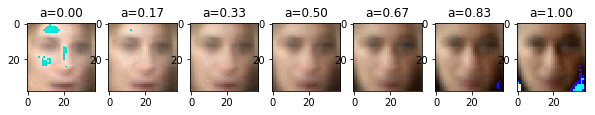

torch.Size([38, 38, 3])
torch.Size([38, 38, 3])
torch.Size([38, 38, 3])
torch.Size([38, 38, 3])
torch.Size([38, 38, 3])
torch.Size([38, 38, 3])
torch.Size([38, 38, 3])


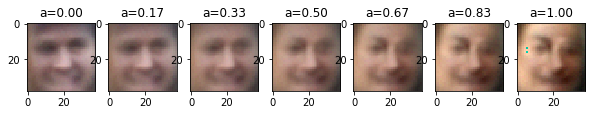

In [ ]:

for _ in range(5):
    image1,image2 = X_test_tensor[np.random.randint(0,len(X_test),size=2)]

    image_pair = torch.cat((image1,image2), 0).cuda(device)
    # ^-- note: depending on your implementation, you may need to call torch.permute here
    
    
    code1, code2 = aenc.enc(image_pair)

    plt.figure(figsize=[10,4])
    for i,a in enumerate(np.linspace(0,1,num=7)):

        output_code = code1*(1-a) + code2*(a)
        output_image = aenc.dec(output_code[None])[0]
        plt.subplot(1,7,i+1)
        plt.imshow(output_image.cpu().detach().numpy())
        plt.title("a=%.2f"%a)
        
    plt.show()

Of course there's a lot more you can do with autoencoders.
If you want to generate images from scratch, however, you're better off using generative adversarial networks.